In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")

# Setup Plotting Style to match team
plt.style.use('seaborn-v0_8-darkgrid')

# Check GPU
print(f"TensorFlow Version: {tf.__version__}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is ready!")
else:
    print("Running on CPU")

# Create output directory
MODEL_DIR = "Universal_LSTM_Results"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

TensorFlow Version: 2.19.0
GPU is ready!


In [2]:
# 1. Load Data
print("Loading FULL dataset...")
df = pd.read_csv('final_training_data_all_regions.csv')
df['time'] = pd.to_datetime(df['time'])

# Sort by Region + Time (Crucial for sequence generation)
df = df.sort_values(by=['region', 'time'])

# 2. Feature Engineering

# A. Time Features (Cyclical)
# Hour (Daily)
df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
# Month (Seasonal - helps with winter vs summer levels)
df['month_sin'] = np.sin(2 * np.pi * df['time'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['time'].dt.month / 12)

# B. Wind Direction Encoding (Keeps Speed separate, fixes 360° jump)
# We convert Degrees (0-360) to Sin/Cos (-1 to 1)
wd_rad = df['wind_direction_10m (°)'] * np.pi / 180
df['wd_sin'] = np.sin(wd_rad)
df['wd_cos'] = np.cos(wd_rad)

# One-Hot Encode Regions
df_encoded = pd.get_dummies(df, columns=['region'], prefix='city')

# 3. Define Features
target_col = 'pm2_5 (μg/m³)'

feature_cols = [
    'pm2_5 (μg/m³)',
    'temperature_2m (°C)',
    'relative_humidity_2m (%)',
    'wind_speed_10m (km/h)',
    'wd_sin', 'wd_cos',
    'nitrogen_dioxide (μg/m³)',
    'dust (μg/m³)',
    'aerosol_optical_depth ()',
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos'
]
city_cols = [col for col in df_encoded.columns if col.startswith('city_')]
all_features = feature_cols + city_cols

print(f"Features Selected: {len(all_features)}")
print(f"Cities included: {city_cols}")

# 4. Scaling
scaler_X = MinMaxScaler()
X_data = scaler_X.fit_transform(df_encoded[all_features])

scaler_y = MinMaxScaler()
y_data = scaler_y.fit_transform(df_encoded[[target_col]])

print(f"Total Rows: {len(df)}")

Loading FULL dataset...
Features Selected: 19
Cities included: ['city_doha', 'city_khor', 'city_qatar', 'city_rayyan', 'city_ummsalal', 'city_wakrah']
Total Rows: 153936


In [3]:
def create_sequences(data_df, x_scaled, y_scaled, time_steps=48):
    Xs, ys = [], []
    # We use the original dataframe 'data_df' to get the group indices
    # but append data from the scaled arrays to ensure we don't mix regions
    for region_name, group in data_df.groupby('region'):
        indices = group.index

        region_X = x_scaled[indices]
        region_y = y_scaled[indices]

        for i in range(len(region_X) - time_steps):
            Xs.append(region_X[i:(i + time_steps)])
            ys.append(region_y[i + time_steps])

    return np.array(Xs), np.array(ys)

TIME_STEPS = 48
print("Creating sequences (this may take a minute)...")
X_seq, y_seq = create_sequences(df, X_data, y_data, TIME_STEPS)

print(f"Final Input Shape: {X_seq.shape}")

# Split Train/Test (95% Train, 5% Test as requested)
split = int(len(X_seq) * 0.95)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")

Creating sequences (this may take a minute)...
Final Input Shape: (153648, 48, 19)
Train samples: 145965 | Test samples: 7683


In [4]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    # Layer 1: Capture broad patterns
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),

    # Layer 2: Capture specific transitions
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.2),

    # Dense Layers for regression
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.Huber(),
              metrics=['mae', 'mse'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

print("Training Universal Model...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Save model
model.save(os.path.join(MODEL_DIR, 'universal_lstm_model.keras'))
print("Model saved.")

Training Universal Model...
Epoch 1/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0022 - mae: 0.0420 - mse: 0.0044 - val_loss: 2.9568e-04 - val_mae: 0.0182 - val_mse: 5.9136e-04 - learning_rate: 0.0010
Epoch 2/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 3.1481e-04 - mae: 0.0174 - mse: 6.2962e-04 - val_loss: 2.2791e-04 - val_mae: 0.0150 - val_mse: 4.5581e-04 - learning_rate: 0.0010
Epoch 3/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 2.2119e-04 - mae: 0.0144 - mse: 4.4237e-04 - val_loss: 2.0966e-04 - val_mae: 0.0155 - val_mse: 4.1932e-04 - learning_rate: 0.0010
Epoch 4/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 1.8970e-04 - mae: 0.0131 - mse: 3.7941e-04 - val_loss: 2.8423e-04 - val_mae: 0.0166 - val_mse: 5.6847e-04 - learning_rate: 0.0010
Epoch 5/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 1.5845e-04 - mae: 0.0117 - mse: 3.1690e-04 - val_loss: 1.7491e-04 - val_mae: 0.0127 - val_mse: 3.4983e-04 - learning_rate: 5.0000e-04
Epoch 

Generating predictions...
--------------------------------------------------

Test Set Metrics:
  MAE: 2.34 μg/m³
  RMSE: 3.46 μg/m³
  R² Score: 0.9466
  MAPE (Inv Accuracy): 6.77%
--------------------------------------------------


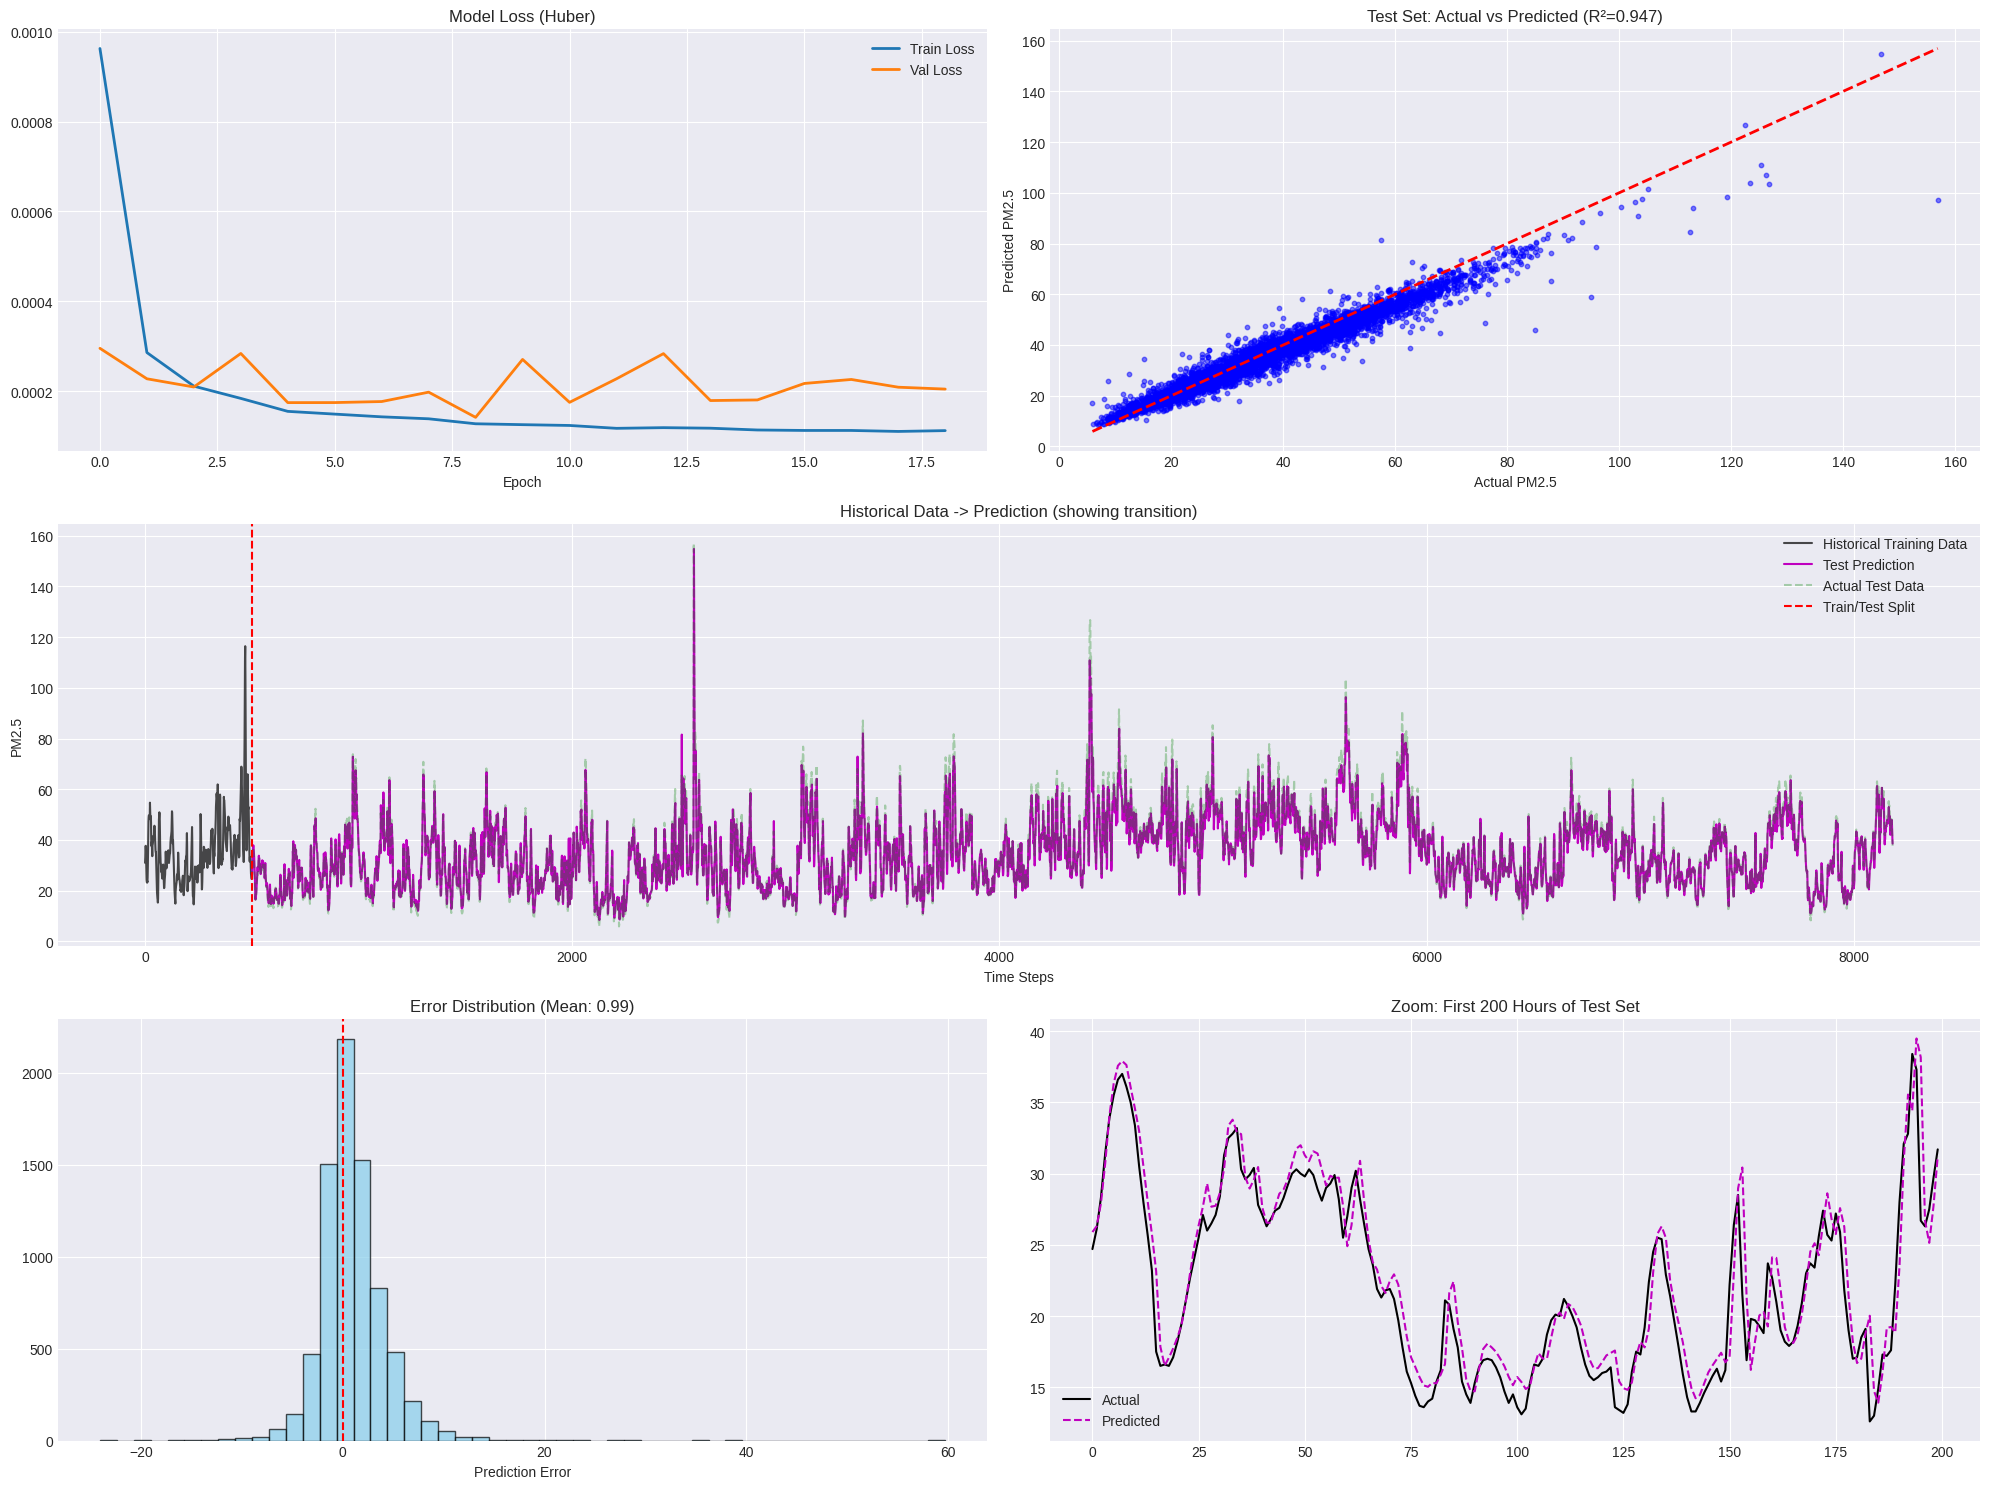

In [5]:
# 1. Predictions & Inverse Scaling
print("Generating predictions...")
y_train_pred_scaled = model.predict(X_train, verbose=0)
y_test_pred_scaled = model.predict(X_test, verbose=0)

# Invert scaling to get real µg/m³ values
y_train_actual = scaler_y.inverse_transform(y_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

y_test_actual = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# 2. Metrics Calculation Function (Matches team format)
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    # MAPE (Mean Absolute Percentage Error) - Regression version of "Accuracy"
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100

    print(f"\n{dataset_name} Metrics:")
    print(f"  MAE: {mae:.2f} μg/m³")
    print(f"  RMSE: {rmse:.2f} μg/m³")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAPE (Inv Accuracy): {mape:.2f}%")

    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

print("-" * 50)
test_metrics = calculate_metrics(y_test_actual, y_test_pred, "Test Set")
print("-" * 50)

# 3. TEAM-STYLE VISUALIZATION
fig = plt.figure(figsize=(20, 15))

# Plot 1: Training History
ax1 = plt.subplot(3, 2, 1)
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_title('Model Loss (Huber)')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot 2: Scatter Plot (Actual vs Predicted)
ax2 = plt.subplot(3, 2, 2)
ax2.scatter(y_test_actual, y_test_pred, alpha=0.5, s=10, c='blue')
# Perfect prediction line
ax2.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--', linewidth=2)
ax2.set_xlabel('Actual PM2.5')
ax2.set_ylabel('Predicted PM2.5')
ax2.set_title(f'Test Set: Actual vs Predicted (R²={test_metrics["r2"]:.3f})')

# Plot 3: Full Data View (End of Train + Test)
# This shows the transition from training data (black) to test predictions (magenta)
ax3 = plt.subplot(3, 1, 2) # Spans full width
display_len = 500  # Show last 500 hours of training + all testing
start_idx = len(y_train_actual) - (display_len)

# Create plotting arrays
train_plot_data = y_train_actual[-display_len:]
test_pred_data = y_test_pred

# X-axis indices
x_train = range(len(train_plot_data))
x_test = range(len(train_plot_data), len(train_plot_data) + len(test_pred_data))

ax3.plot(x_train, train_plot_data, 'k-', label='Historical Training Data', alpha=0.7)
ax3.plot(x_test, test_pred_data, 'm-', label='Test Prediction', linewidth=1.5)
# Also plot actual test data lightly to see accuracy
ax3.plot(x_test, y_test_actual, 'g--', label='Actual Test Data', alpha=0.3)

ax3.axvline(x=len(train_plot_data), color='r', linestyle='--', label='Train/Test Split')
ax3.set_title(f'Historical Data -> Prediction (showing transition)')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('PM2.5')
ax3.legend()

# Plot 4: Error Distribution
ax4 = plt.subplot(3, 2, 5)
errors = y_test_actual - y_test_pred
ax4.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(x=0, color='r', linestyle='--')
ax4.set_title(f'Error Distribution (Mean: {errors.mean():.2f})')
ax4.set_xlabel('Prediction Error')

# Plot 5: Zoomed in Test Forecast
ax5 = plt.subplot(3, 2, 6)
ax5.plot(y_test_actual[:200], 'k-', label='Actual')
ax5.plot(y_test_pred[:200], 'm--', label='Predicted')
ax5.set_title('Zoom: First 200 Hours of Test Set')
ax5.legend()

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'team_style_results.png'))
plt.show()

Generating 24-hour Autoregressive Forecast for city_doha...
Forecasting from: 2025-12-04 23:00:00
Forecast Complete.


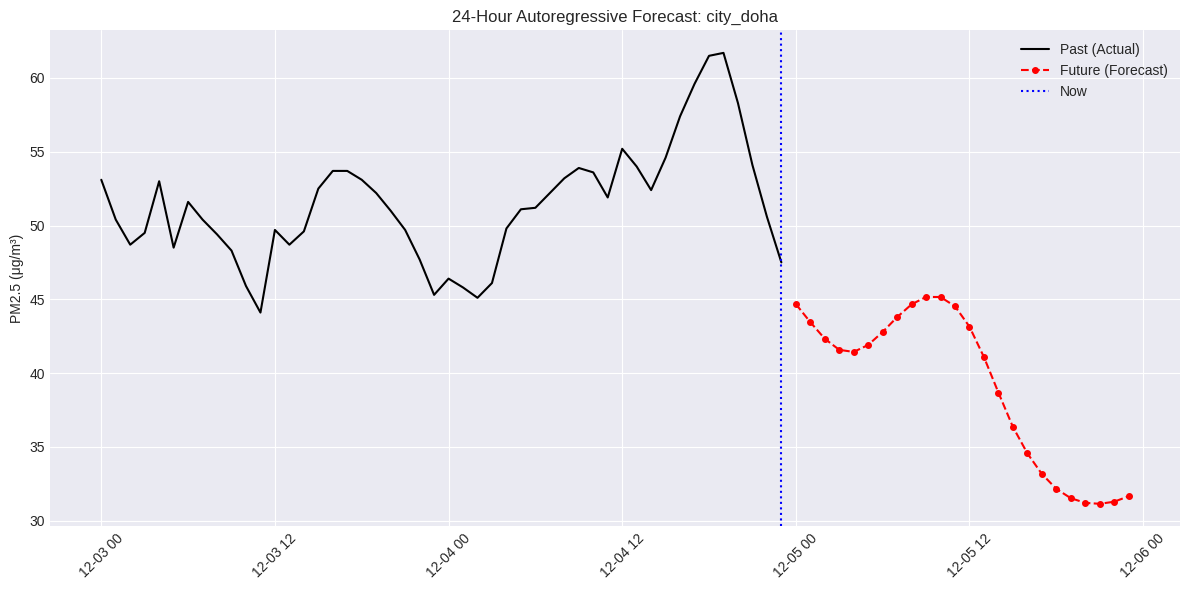

                  Time  Predicted_PM2.5
0  2025-12-05 00:00:00        44.674896
1  2025-12-05 01:00:00        43.450909
2  2025-12-05 02:00:00        42.326408
3  2025-12-05 03:00:00        41.573723
4  2025-12-05 04:00:00        41.431961
5  2025-12-05 05:00:00        41.906090
6  2025-12-05 06:00:00        42.784279
7  2025-12-05 07:00:00        43.790203
8  2025-12-05 08:00:00        44.656830
9  2025-12-05 09:00:00        45.158123
10 2025-12-05 10:00:00        45.153824
11 2025-12-05 11:00:00        44.524574
12 2025-12-05 12:00:00        43.143566
13 2025-12-05 13:00:00        41.083298
14 2025-12-05 14:00:00        38.677101
15 2025-12-05 15:00:00        36.355305
16 2025-12-05 16:00:00        34.559505
17 2025-12-05 17:00:00        33.163914
18 2025-12-05 18:00:00        32.153435
19 2025-12-05 19:00:00        31.520370
20 2025-12-05 20:00:00        31.201839
21 2025-12-05 21:00:00        31.138418
22 2025-12-05 22:00:00        31.278488
23 2025-12-05 23:00:00        31.651556


In [6]:
# ==========================================
# CELL 6: Autoregressive Future Forecast
# ==========================================
from datetime import timedelta

# Configuration
FORECAST_HOURS = 24
TARGET_CITY_PREFIX = 'city_doha'

print(f"Generating {FORECAST_HOURS}-hour Autoregressive Forecast for {TARGET_CITY_PREFIX}...")

# 1. Get the last sequence of real data for the specific city
city_df = df_encoded[df_encoded[TARGET_CITY_PREFIX] == 1].copy()
last_sequence_df = city_df.iloc[-TIME_STEPS:]
last_time = city_df['time'].iloc[-1]

print(f"Forecasting from: {last_time}")

# 2. Scale the initial sequence
# Note: 'all_features' now includes 'pm2_5' (from Step 1), so scaler_X handles it automatically
current_batch = scaler_X.transform(last_sequence_df[all_features])
current_batch = current_batch.reshape(1, TIME_STEPS, len(all_features))

# 3. Find Feature Indices for Updates
# We need to know where PM2.5 and Time features are located in the array
pm25_idx = all_features.index(target_col)
h_sin_idx = all_features.index('hour_sin')
h_cos_idx = all_features.index('hour_cos')

# 4. Forecast Loop
future_predictions = []
future_dates = []
current_time = last_time

for i in range(FORECAST_HOURS):
    # A. Predict Next Hour
    pred_scaled = model.predict(current_batch, verbose=0)

    # Save the prediction (unscaled) for the graph
    pred_value = scaler_y.inverse_transform(pred_scaled)[0][0]
    future_predictions.append(pred_value)

    # Calculate next timestamp
    next_time = current_time + timedelta(hours=1)
    future_dates.append(next_time)

    # B. PREPARE NEXT INPUT (The Feedback Loop)
    # Get the latest row of features
    next_features = current_batch[0, -1, :].copy()

    # [CRITICAL STEP] Update the PM2.5 Input with our *Predicted* Value
    # The model relies on this "history" to know if pollution is going up or down.
    # Note: We use the SCALED prediction directly because the input must be scaled.
    next_features[pm25_idx] = pred_scaled[0][0]

    # Update Time Features (So the model knows it's a new hour)
    next_features[h_sin_idx] = np.sin(2 * np.pi * next_time.hour / 24)
    next_features[h_cos_idx] = np.cos(2 * np.pi * next_time.hour / 24)

    # Update Weather Features?
    # Since we don't have a weather forecast, we keep Wind/Temp "Persistent" (same as last hour).
    # This is standard for short-term forecasts without external data.

    # Reshape features to match batch dimensions: (1, 1, n_features)
    next_features = next_features.reshape(1, 1, len(all_features))

    # C. Update the Batch (Sliding Window)
    # Remove the oldest hour (index 0) and add the new predicted hour (at the end)
    current_batch = np.append(current_batch[:, 1:, :], next_features, axis=1)

    current_time = next_time

print(f"Forecast Complete.")

# 5. Visualization
plt.figure(figsize=(12, 6))

# Plot recent history (Real Data)
history_hours = 48
plt.plot(city_df['time'].iloc[-history_hours:],
         city_df[target_col].iloc[-history_hours:],
         label='Past (Actual)', color='black', linewidth=1.5)

# Plot forecast (Predicted Data)
plt.plot(future_dates, future_predictions,
         label='Future (Forecast)', color='red', marker='o', markersize=4, linestyle='--')

plt.axvline(x=last_time, color='blue', linestyle=':', label='Now')
plt.title(f'24-Hour Autoregressive Forecast: {TARGET_CITY_PREFIX}')
plt.ylabel('PM2.5 (μg/m³)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print Table
forecast_df = pd.DataFrame({'Time': future_dates, 'Predicted_PM2.5': future_predictions})
print(forecast_df.head(24))

Loading model from: Universal_LSTM_Results/universal_lstm_model.keras
Model loaded successfully!
Loading Training Data to fit Scalers...
Total Features Expected: 19

Processing Test File: final_test_data_all_regions.csv

Evaluating Region: DOHA...
  Predicting 144 hours...
  > R²: 0.9305 | RMSE: 2.59


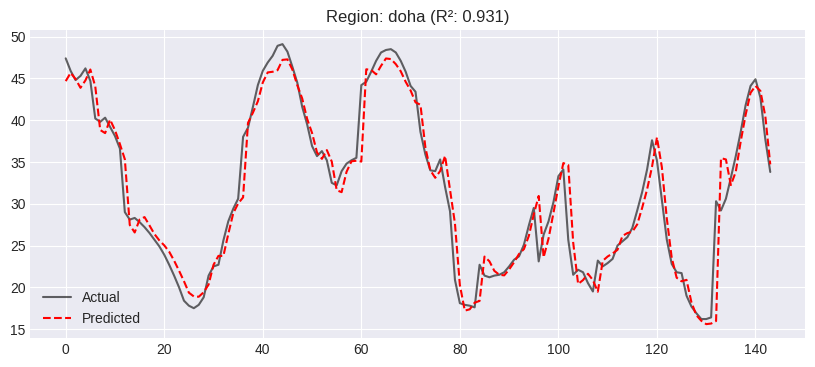


Evaluating Region: KHOR...
  Predicting 144 hours...
  > R²: 0.9049 | RMSE: 2.58


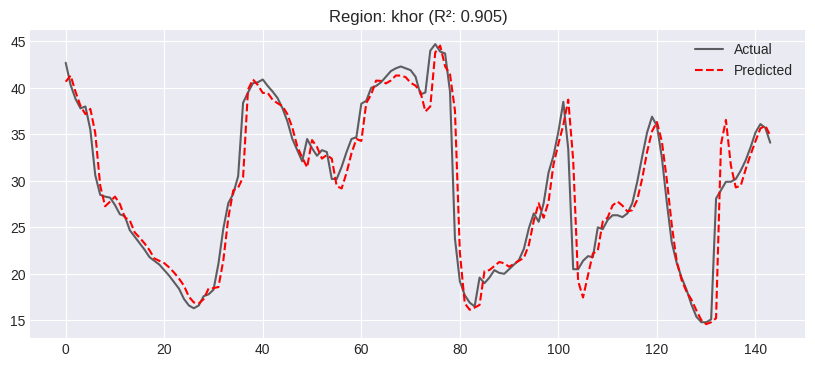


Evaluating Region: QATAR...
  Predicting 144 hours...
  > R²: 0.8902 | RMSE: 3.08


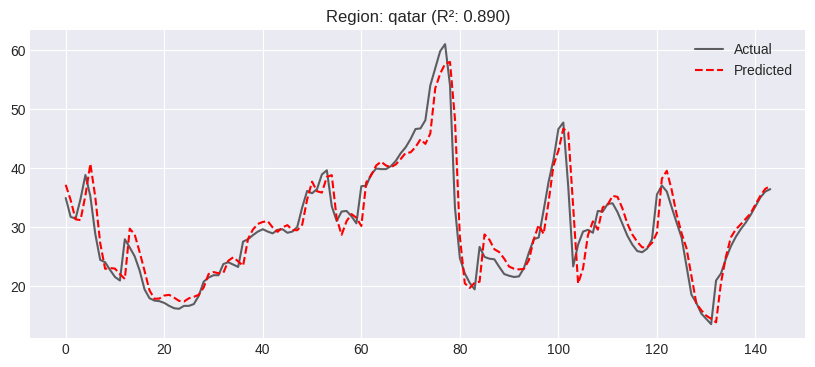


Evaluating Region: RAYYAN...
  Predicting 144 hours...
  > R²: 0.9298 | RMSE: 2.60


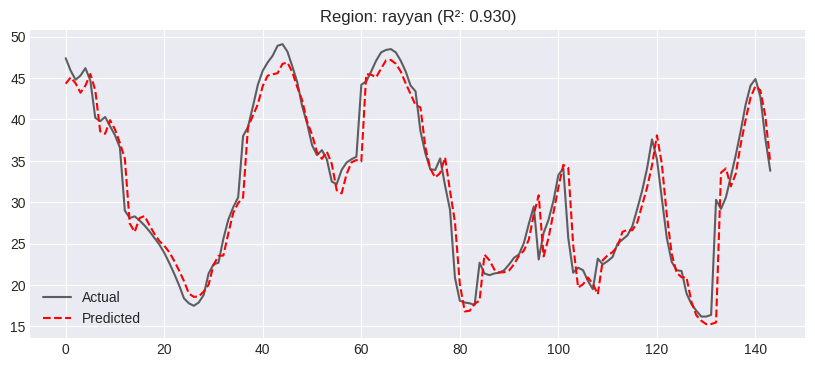


Evaluating Region: WAKRAH...
  Predicting 144 hours...
  > R²: 0.9298 | RMSE: 2.60


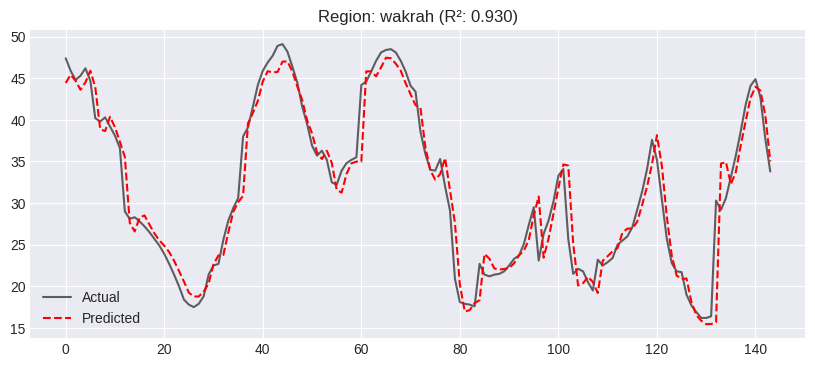


Evaluating Region: UMMSALAL...
  Predicting 144 hours...
  > R²: 0.8891 | RMSE: 3.10


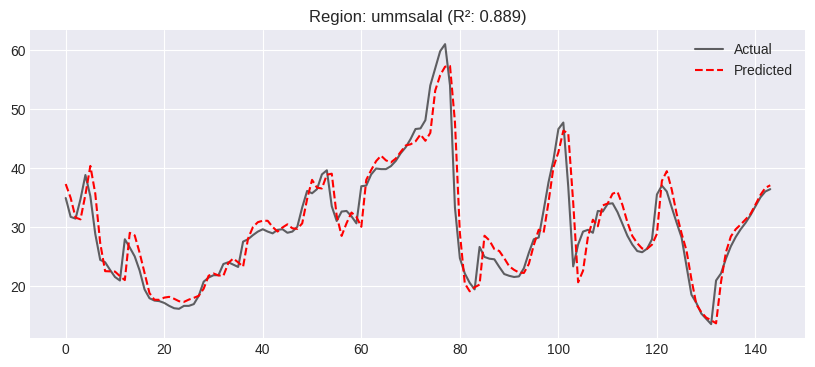


GLOBAL TEST RESULTS:
  R² Score: 0.9145
  RMSE:     2.77 μg/m³
  MAE:      1.83 μg/m³


In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-darkgrid')

# ==========================================
# CONFIGURATION
# ==========================================
MODEL_PATH = "Universal_LSTM_Results/universal_lstm_model.keras"
TRAIN_FILE = "final_training_data_all_regions.csv"
TEST_FILE = "final_test_data_all_regions.csv"
TIME_STEPS = 48 # Ensure this matches what you used in training (48 or 72)

# ==========================================
# 1. HELPER: YOUR SPECIFIC FEATURE ENGINEERING
# ==========================================
def engineer_features(df):
    """Applies the winning Hybrid + Autoregressive feature set"""
    df = df.copy()

    # 1. Time Features
    df['time'] = pd.to_datetime(df['time'])
    df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['time'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['time'].dt.month / 12)

    # 2. Wind Hybrid Features (Raw Speed + Direction Sin/Cos)
    wd_rad = df['wind_direction_10m (°)'] * np.pi / 180
    df['wd_sin'] = np.sin(wd_rad)
    df['wd_cos'] = np.cos(wd_rad)

    # 3. One Hot Encoding for Regions
    # Note: In a real deployment, you might handle this differently,
    # but for this test we match the training setup.
    df = pd.get_dummies(df, columns=['region'], prefix='city')

    return df

# ==========================================
# 2. LOAD & PREPARE
# ==========================================
print(f"Loading model from: {MODEL_PATH}")
if os.path.exists(MODEL_PATH):
    model = keras.models.load_model(MODEL_PATH)
    print("Model loaded successfully!")
else:
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")

# Load Training Data to Fit Scalers
print("Loading Training Data to fit Scalers...")
df_train_raw = pd.read_csv(TRAIN_FILE)
df_train = engineer_features(df_train_raw)

# DEFINE THE EXACT FEATURE LIST FROM YOUR WINNING MODEL
target_col = 'pm2_5 (μg/m³)'
feature_cols = [
    'pm2_5 (μg/m³)',           # Autoregressive Input
    'temperature_2m (°C)',
    'relative_humidity_2m (%)',
    'wind_speed_10m (km/h)',   # Hybrid: Raw Speed
    'wd_sin', 'wd_cos',        # Hybrid: Encoded Direction
    'nitrogen_dioxide (μg/m³)',
    'dust (μg/m³)',
    'aerosol_optical_depth ()',
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos'
]
# Add city columns dynamically
city_cols = [col for col in df_train.columns if col.startswith('city_')]
all_features = feature_cols + city_cols

print(f"Total Features Expected: {len(all_features)}")

# Fit Scalers
scaler_X = MinMaxScaler()
scaler_X.fit(df_train[all_features])

scaler_y = MinMaxScaler()
scaler_y.fit(df_train[[target_col]])

# ==========================================
# 3. RUN TEST ON NEW DATA
# ==========================================
print(f"\nProcessing Test File: {TEST_FILE}")
df_test_raw = pd.read_csv(TEST_FILE)
df_test_raw['time'] = pd.to_datetime(df_test_raw['time'])

# We need to process each region separately to maintain continuity
regions = df_test_raw['region'].unique()
global_actuals = []
global_preds = []

for region in regions:
    print(f"\nEvaluating Region: {region.upper()}...")

    # 1. Isolate Region Data
    region_test = df_test_raw[df_test_raw['region'] == region].sort_values('time')

    # 2. Get Context from Training (Last 48 hours for this region)
    # We need this to predict the *first* hour of the test set
    region_train_context = df_train_raw[df_train_raw['region'] == region].sort_values('time').iloc[-TIME_STEPS:]

    # 3. Combine & Engineer
    combined_raw = pd.concat([region_train_context, region_test]).reset_index(drop=True)
    combined_eng = engineer_features(combined_raw)

    # Align Columns (Ensure all city columns exist, fill missing with 0)
    for col in city_cols:
        if col not in combined_eng.columns:
            combined_eng[col] = 0
    combined_eng = combined_eng[all_features] # Reorder to match exactly

    # 4. Scale
    X_scaled = scaler_X.transform(combined_eng)
    y_scaled = scaler_y.transform(combined_eng[[target_col]])

    # 5. Create Sequences
    Xs, ys = [], []
    for i in range(len(X_scaled) - TIME_STEPS):
        Xs.append(X_scaled[i:(i + TIME_STEPS)])
        ys.append(y_scaled[i + TIME_STEPS])

    X_seq = np.array(Xs)
    y_seq = np.array(ys)

    if len(X_seq) == 0:
        print("  Not enough data to create sequences.")
        continue

    # 6. Predict
    print(f"  Predicting {len(X_seq)} hours...")
    preds_scaled = model.predict(X_seq, verbose=0)

    # 7. Inverse Scale
    preds = scaler_y.inverse_transform(preds_scaled)
    actuals = scaler_y.inverse_transform(y_seq)

    # 8. Store & Plot
    global_actuals.extend(actuals)
    global_preds.extend(preds)

    r2 = r2_score(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    print(f"  > R²: {r2:.4f} | RMSE: {rmse:.2f}")

    plt.figure(figsize=(10, 4))
    plt.plot(actuals, 'k-', label='Actual', alpha=0.6)
    plt.plot(preds, 'r--', label='Predicted', linewidth=1.5)
    plt.title(f'Region: {region} (R²: {r2:.3f})')
    plt.legend()
    plt.show()

# ==========================================
# 4. FINAL GLOBAL METRICS
# ==========================================
print("\n" + "="*50)
if len(global_actuals) > 0:
    g_r2 = r2_score(global_actuals, global_preds)
    g_rmse = np.sqrt(mean_squared_error(global_actuals, global_preds))
    g_mae = mean_absolute_error(global_actuals, global_preds)

    print(f"GLOBAL TEST RESULTS:")
    print(f"  R² Score: {g_r2:.4f}")
    print(f"  RMSE:     {g_rmse:.2f} μg/m³")
    print(f"  MAE:      {g_mae:.2f} μg/m³")
else:
    print("No predictions were made.")
print("="*50)